# 데이터를 전처리 하시오(결측, 이상치 처리)

In [56]:
import pandas as pd
df = pd.read_csv('../data/airquality.csv')


In [57]:
# Ozone,Solar.R 등의 수치형 변수와 범주형 변수 중 순서형 변수인 Month와 Day가 존재함을 알 수 있다.
# 단순 날짜 변수인 Day는 삭제한다.
df.info()
df = df.drop('Day',axis = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ozone    116 non-null    float64
 1   Solar.R  146 non-null    float64
 2   Wind     153 non-null    float64
 3   Temp     153 non-null    int64  
 4   Month    153 non-null    int64  
 5   Day      153 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 7.3 KB


<BarContainer object of 5 artists>

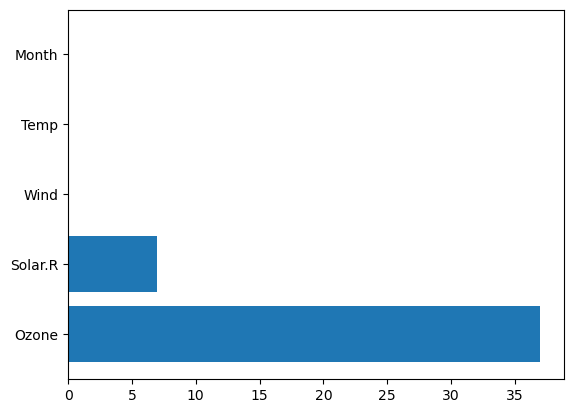

In [58]:
# 현재 Solar.R, Ozone에 결측치가 있음을 확인할 수 있다. 
# 데이터 수가 많지 않으므로 결측치를 삭제하기보단 결측을 채우는 방법이 더 타당해 보인다.
import matplotlib.pyplot as plt
nulls = df.isnull().sum()
plt.barh(nulls.index,nulls.values)

In [59]:
# 보간하는 방법은 수치형 변수인지 범주형 변수인지에 따라 방법이 다르다. 현재 수치형 변수들이 결측값을 가지고 있으므로 
# 각 변수의 대표값인 평균값으로 결측을 채우려했으나 이는 이상치에 민감하다는 단점이 있으므로 
# 각 변수의 중앙값으로 결측을 대체한다. 
df['Ozone'].fillna(df['Ozone'].median(),inplace = True)
df['Solar.R'].fillna(df['Solar.R'].median(),inplace = True)

<BarContainer object of 5 artists>

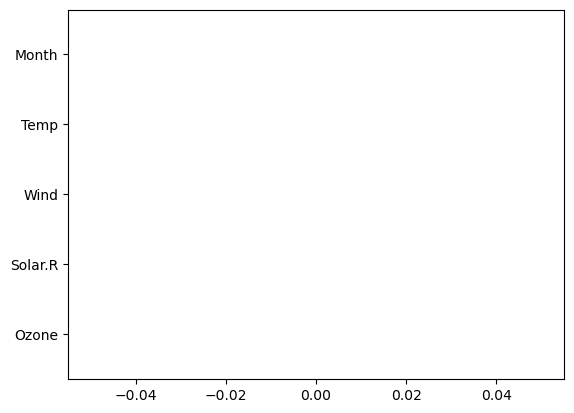

In [60]:
# Solar.R, Ozone에 결측치가 사라졌음을 확인할 수 있다
import matplotlib.pyplot as plt
nulls = df.isnull().sum()
plt.barh(nulls.index,nulls.values)

In [1]:
# 이상치의 경우, Ozone과 wind의 값의 범위나 분포를 봤을 때 
# 이상치라고 볼 수 없어서 이상치 처리를 하지 않았다.
fig, axes = plt.subplots(2,3)
# 수치형 변수만 sorting한다
feats = [col for col in df.columns if df[col].dtypes != object]
for ax, col in zip(axes.ravel(), feats):
    ax.boxplot(df[[col]])
    ax.set_xticklabels([col])
plt.show()

NameError: name 'plt' is not defined

# Temp 변수로 회귀변수를 실시하고, 새로 생서한 이분변수로 분류분석을 수행하시오


In [62]:
# 변수 간의 척도가 다르면 회귀계수가 왜곡될 수 있으므로, feature scaling을 진행한 후 회귀계수를
# 분석하기로 한다. 회귀분석 결과, ~~ 변수가 가장 중요한 변수로 판단된다.
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np

X = df.drop(['Temp'],axis = 1)
# 변수 간의 척도가 다르면 회귀계수가 왜곡될 수 있으므로, feature Scaling을 진행한 후 회귀계수를 분석하기로 한다.
sc = RobustScaler()
scaled_X = sc.fit_transform(X)

y = df['Temp']

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y)
lr = LinearRegression()
lr.fit(X_train, y_train)
result = pd.DataFrame({'feat':X.columns, 'coef':lr.coef_})
result['abs_coef'] = result['coef'].apply(lambda x: np.abs(x))
result.sort_values(by='abs_coef', ascending = False).head()

,feat,coef,abs_coef
3,Month,4.150993,4.150993
0,Ozone,2.822125,2.822125
1,Solar.R,2.261969,2.261969
2,Wind,-1.812580,1.812580


In [63]:
# 회귀 분석 결과 , Temp변수(온도)는 회귀계수의 절대값이 큰 Month(월), Ozone, Solar변수가 가장 중요한 변수로 판단된다.

In [64]:
y_pred = lr.predict(X_test)
resid = y_test - y_pred

print('score:',lr.score(X_test,y_test))
print('mse:', (resid**2).sum()/len(y_test))
print('rmse:', np.sqrt((resid**2).sum()/len(y_test)))


score: 0.5147792717462111
mse: 61.324116102712594
rmse: 7.830971593787874


In [65]:
# 분류분석 시행하기 위해 temp의 범주를 정한다. 최소값은 56, 최대값은 97이므로 총
# 50~60-> 1, 60~70 -> 2, 70~80 -> 3, 80~90 -> 4, 90~100 -> 5로 범주화 시킨다.
df.loc[(df['Temp'] > 50) & (df['Temp'] <= 60),'New_temp'] = 0
df.loc[(df['Temp'] > 60) & (df['Temp'] <= 70),'New_temp'] = 1
df.loc[(df['Temp'] > 70) & (df['Temp'] <= 80),'New_temp'] = 2
df.loc[(df['Temp'] > 80) & (df['Temp'] <= 90),'New_temp'] = 3
df.loc[(df['Temp'] > 90) & (df['Temp'] <= 100),'New_temp'] = 4

df.head(10)

,Ozone,Solar.R,Wind,Temp,Month,New_temp
0,41.0,190.0,7.4,67,5,1.0
1,36.0,118.0,8.0,72,5,2.0
2,12.0,149.0,12.6,74,5,2.0
3,18.0,313.0,11.5,62,5,1.0
4,31.5,205.0,14.3,56,5,0.0
5,28.0,205.0,14.9,66,5,1.0
6,23.0,299.0,8.6,65,5,1.0
7,19.0,99.0,13.8,59,5,0.0
8,8.0,19.0,20.1,61,5,1.0
9,31.5,194.0,8.6,69,5,1.0


In [66]:
#분류 분석을 하기위해 앙상블 모델인 xgboost 분류모형을 사용한다. 
# 이미 회귀분석 시 Scaled_X를 만들었으므로 
df['New_temp'] = df['New_temp'].astype(int).astype('object')
y = df['New_temp']

X_train1, X_test1, y_train1, y_test1 = train_test_split(scaled_X, y,stratify = y ,test_size = 0.3, random_state = 2023)

from xgboost import XGBClassifier

# 모델 선언 예시
model = XGBClassifier(random_state = 2023)
model.fit(X_train1, y_train1)

# 분류기 성능 평가
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test1) #예측 라벨 
accuracy_score(y_pred, y_test1)

ValueError: Classification metrics can't handle a mix of multiclass and unknown targets

In [69]:
y_test1

98     3
31     2
60     3
101    4
112    2
7      0
120    4
22     1
143    1
126    4
48     1
94     3
82     3
83     3
75     2
114    2
27     1
36     2
51     2
104    3
9      1
67     3
142    3
144    2
147    1
37     3
26     0
150    2
103    3
32     2
129    2
66     3
135    2
0      1
88     3
12     1
128    3
149    2
79     3
2      2
131    2
43     3
72     2
123    4
58     2
84     3
Name: New_temp, dtype: object